# Global Variables

In [1]:
V = 0.02 # frequency mismatch

# phase-coherent regime
# a_X = 0.16
# a_Y = 0.16
# b_X = 0.1
# b_Y = 0.1
# c_X = 8.5
# c_Y = 8.5
# mu_max = 0.26
# mu_samples = 24
# num_simulations = 10
# state_samples = 20


# funnel regime
a_X = 0.2925
a_Y = 0.2925
b_X = 0.1
b_Y = 0.1
c_X = 8.5
c_Y = 8.5
mu_max = 0.4
mu_samples = 42
num_simulations = 10
state_samples = 20

dt = 0.01 # simulation step
T = 5000 # simulation time, number of states = T/dt
transient = 100_000 # number of early discarded states

N = [1500, 1500] # number of states to bootstrap in either system

RR = [ # ideal RRs
    [0.03, 0.02],
    [0.02, 0.03]
]

# Simulation

## Numerical integration

In [2]:
import random

def x_dot(x, y, mu_yx):
    return [
        -(1+V)*x[1]-x[2],
        (1+V)*x[0]+a_X*x[1]+mu_yx*(y[1]-x[1]),
        b_X+x[2]*(x[0]-c_X)
    ]

def y_dot(x, y, mu_xy):
    return [
        -(1-V)*y[1]-y[2],
        (1-V)*y[0]+a_Y*y[1]+mu_xy*(x[1]-y[1]),
        b_Y+y[2]*(y[0]-c_Y)
    ]

def get_perfect_states(mu_xy, mu_yx):
    states = [[], []]

    t = 0
    x = [random.uniform(0, 1) for _ in range(3)]
    y = [random.uniform(0, 1) for _ in range(3)]
    while t < T:
        states[0].append(x)
        states[1].append(y)
        current_x_dot = x_dot(x, y, mu_yx)
        current_y_dot = y_dot(x, y, mu_xy)
        x = [x[i] + current_x_dot[i] * dt for i in range(3)]
        y = [y[i] + current_y_dot[i] * dt for i in range(3)]

        t += dt

    return [states[0][transient:], states[1][transient:]]


## Sampling

In [3]:
def get_bootstrapped_states(states = None):
    if states is None:
        states = get_perfect_states()

    return [
        random.sample(states[0], N[0]),
        random.sample(states[1], N[1])
    ]

# Generating Graph

## Generating Edge List with Given Epsilon

In [4]:
import numpy as np
from scipy.spatial.distance import pdist, cdist


def get_edge_list(subgraph, epsilon, states = None, metric='euclidean'):
    if states is None:
        states = get_bootstrapped_states()

    if subgraph[0] == subgraph[1]:
        s = np.asarray(states[subgraph[0]])
        dists = pdist(s, metric=metric)
        mask = dists < epsilon

        triu_indices = np.triu_indices(s.shape[0], k=1)
        edges = list(zip(triu_indices[0][mask] + (N[0] if subgraph[0] == 1 else 0), triu_indices[1][mask] + (N[0] if subgraph[1] == 1 else 0)))

        return edges

    s = [np.asarray(states[subgraph[0]]), np.asarray(states[subgraph[1]])]
    dists = cdist(s[0], s[1], metric=metric)
    i_idx, j_idx = np.where(dists <= epsilon)
    edges = [(i, j + N[0]) for i, j in zip(i_idx, j_idx)]

    return edges

## Finding suitable epsilons

In [5]:
import numpy as np

def get_epsilon(bootstrapped_states, RR=RR):
    X1 = bootstrapped_states[0]  # system 1
    X2 = bootstrapped_states[1]  # system 2

    from scipy.spatial.distance import pdist, cdist

    def epsilon_within(X, rr_target=RR[0][0], theiler=0, metric='euclidean'):
        X = np.asarray(X)
        dists = pdist(X, metric=metric)

        # n = X.shape[0]
        # if theiler > 0:
        #     mask = np.ones(dists.shape[0], dtype=bool)
        #     idx = 0
        #     for i in range(n - 1):
        #         for j in range(i + 1, n):
        #             if (j - i) <= theiler:
        #                 mask[idx] = False
        #             idx += 1
        #     filtered = dists[mask]
        #     total_pairs = (n * (n - 1)) // 2
        #     target_pairs = max(1, int(np.round(rr_target * total_pairs)))
        #     if target_pairs > filtered.size:
        #         return float(np.max(filtered))
        #     k = target_pairs - 1
        #     return float(np.partition(filtered, k)[k])

        total_pairs = dists.size
        k = max(0, int(np.round(rr_target * total_pairs)) - 1)
        return float(np.partition(dists, k)[k])

    def epsilon_cross(rr_target=RR[0][1], metric='euclidean'):
        X = [np.asarray(X1), np.asanyarray(X2)]
        dists = cdist(X[0], X[1], metric=metric).ravel()
        total_pairs = dists.size / 2
        k = max(0, int(np.round(rr_target * total_pairs)) - 1)
        return float(np.partition(dists, k)[k])

    def epsilons_for_two_systems(rr11=0.03, rr22=0.03, rr12=0.02, theiler1=0, theiler2=0, metric='euclidean'):
        eps11 = epsilon_within(X1, rr_target=RR[0][0])
        eps22 = epsilon_within(X2, rr_target=RR[1][1])
        eps12 = epsilon_cross()
        return eps11, eps22, eps12

    eps11, eps22, eps12 = epsilons_for_two_systems()
    return [
        [eps11, eps12],
        [eps12, eps22]
    ]

## Constructing edge list with proper epsilons

In [6]:
def get_balanced_edge_list(states = None):
    if states is None:
        states = get_bootstrapped_states()

    epsilon = get_epsilon(states)
    subgraphs = [[0,0], [0,1], [1,1]]
    edges = []
    for subgraph in subgraphs:
        list = get_edge_list(subgraph, epsilon[subgraph[0]][subgraph[1]], states)
        # current_RR = 2*len(list)/(N[subgraph[0]] * N[subgraph[1]])
        # print(f"subgraph: {subgraph}, epsilon: {epsilon[subgraph[0]][subgraph[1]]:.4f}, edges: {len(list)}, RR: {current_RR:.4f}, error(%): {100*(current_RR/RR[subgraph[0]][subgraph[1]] - 1):+.4f}")
        edges = edges + list

    return edges

# Analysing Networks

## Calculating Network Properties

In [7]:
import numpy as np

def get_properties(matrix, dir=0):
    sub1 = np.arange(N[0])
    sub2 = np.arange(N[0], N[0]+N[1])
    if dir:
        sub1, sub2 = sub2, sub1
    
    # calculating global cross-clustering coefficient
    local_vals = []
    for v in sub1:
        neighbors = sub2[matrix[v, sub2] > 0] # neighbors of v in sub2
        k = len(neighbors)
        if k < 2:
            local_vals.append(0)
            continue
        
        # Count edges between neighbors
        sub_adj = matrix[np.ix_(neighbors, neighbors)]
        links = np.sum(sub_adj)
        Cv = links / (k * (k - 1))
        local_vals.append(Cv)

    GCC = np.mean(local_vals) if local_vals else 0.0

    # calculating cross-transitivity
    matrix22 = matrix[np.ix_(sub2, sub2)]
    matrix12 = matrix[np.ix_(sub1, sub2)]

    found = 0
    tested = 0
    for neighbors in matrix12:
        idx = np.where(neighbors)[0]
        k = len(idx)
        if k < 2:
            continue
        tested += k * (k-1) // 2
        submatrix = matrix22[np.ix_(idx, idx)]
        found += np.sum(np.triu(submatrix, k=1))

    CT = 0 if tested == 0 else found/tested

    return GCC, CT

In [8]:
def analyse_states(perfect_states):
    bootstrapped_states = get_bootstrapped_states(perfect_states)
    # print("states sampled")
    edges = get_balanced_edge_list(bootstrapped_states)
    # print("edges balanced")
    matrix = np.zeros((N[0] + N[1], N[0] + N[1]), dtype=int)

    for u, v in edges:
        matrix[u,v] = 1
        matrix[v,u] = 1

    C_XY, T_XY = get_properties(matrix, 0)
    C_YX, T_YX = get_properties(matrix, 1)
    # print(f"C_XY: {C_XY:.4f}, C_YX: {C_YX:.4f}, difference(%): {100 * (max(C_XY, C_YX) / min(C_XY, C_YX) - 1):.4f}, coupling direction: ", "X -> Y" if C_YX > C_XY else "Y -> X")
    # print(f"T_XY: {T_XY:.4f}, T_YX: {T_YX:.4f}, difference(%): {100 * (max(T_XY, T_YX) / min(T_XY, T_YX) - 1):.4f}, coupling direction: ", "X -> Y" if T_YX > T_XY else "Y -> X")

    return C_XY, C_YX, T_XY, T_YX

## Running full analysis
Long process ~ 1min/#cores/#correlation_types

In [9]:
from joblib import Parallel, delayed, parallel_backend

xy_changing = False
yx_changing = False
def analyse_at_correlation_index(correlation_index):
    arr = []
    for i in range(num_simulations):
        states = get_perfect_states(mu_max * correlation_index / (mu_samples - 1) if xy_changing else 0, mu_max * correlation_index / (mu_samples - 1) if yx_changing else 0)
        for j in range(state_samples):
            C_XY, C_YX, T_XY, T_YX = analyse_states(states)
            arr.append([C_XY, C_YX, T_XY, T_YX])
    print(f"#{correlation_index} done on {'XY' if xy_changing and yx_changing else ('Xy' if xy_changing else 'xY')}")
    return arr

correlation_indices = list(range(mu_samples))

def compute():
    print("Running analysis")
    return Parallel()(
        delayed(analyse_at_correlation_index)(ci)
        for ci in correlation_indices
    )

# file_name = "X>Y.npy" # X->Y
# xy_changing = True
# yx_changing = False
# with parallel_backend('loky'):
#     Xy = compute()

# np.save(file_name, Xy)
# print(f"analysis Xy done, saved to {file_name}")

# file_name = "X=Y.npy" # X<->Y
# xy_changing = True
# yx_changing = True
# with parallel_backend('loky'):
#     XY = compute()

# np.save(file_name, XY)
# print("analysis XY done, saved to {file_name}")

# file_name = "X<Y.npy" # Y->X
# xy_changing = False
# yx_changing = True
# with parallel_backend('loky'):
#     xY = compute()

# np.save(file_name, xY)
# print("analysis xY done, saved to {file_name}")

# Plots

## Plot of C_XY, C_YX, T_XY and T_YX for X->Y, X<->Y and Y->X in the funnel region

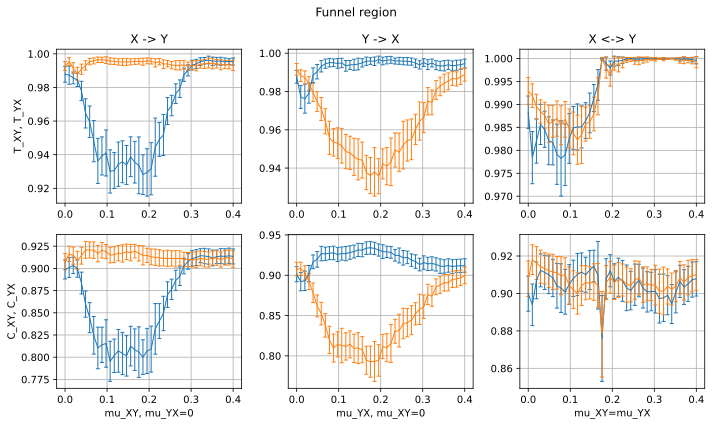

In [14]:
analysis_Xy = np.load("X>Y_funnel.npy")
analysis_XY = np.load("X=Y_funnel.npy")
analysis_xY = np.load("X<Y_funnel.npy")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

correlation_index = np.arange(0, len(analysis_Xy))
mu = 0.4 * correlation_index / (len(analysis_XY) - 1)

averages_Xy = np.mean(analysis_Xy, axis=1)
errors_Xy = np.std(analysis_Xy, axis=1)

averages_XY = np.mean(analysis_XY, axis=1)
errors_XY = np.std(analysis_XY, axis=1)

averages_xY = np.mean(analysis_xY, axis=1)
errors_xY = np.std(analysis_xY, axis=1)

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs[0, 0].errorbar(mu, averages_Xy[:, 2], yerr=errors_Xy[:, 2], linestyle='-', linewidth=1, capsize=2, label='T_XY')
axs[0, 0].errorbar(mu, averages_Xy[:, 3], yerr=errors_Xy[:, 3], linestyle='-', linewidth=1, capsize=2, label='T_YX')
axs[1, 0].errorbar(mu, averages_Xy[:, 0], yerr=errors_Xy[:, 0], linestyle='-', linewidth=1, capsize=2, label='C_XY')
axs[1, 0].errorbar(mu, averages_Xy[:, 1], yerr=errors_Xy[:, 1], linestyle='-', linewidth=1, capsize=2, label='C_YX')

axs[0, 1].errorbar(mu, averages_xY[:, 2], yerr=errors_xY[:, 2], linestyle='-', linewidth=1, capsize=2, label='T_XY')
axs[0, 1].errorbar(mu, averages_xY[:, 3], yerr=errors_xY[:, 3], linestyle='-', linewidth=1, capsize=2, label='T_YX')
axs[1, 1].errorbar(mu, averages_xY[:, 0], yerr=errors_xY[:, 0], linestyle='-', linewidth=1, capsize=2, label='C_XY')
axs[1, 1].errorbar(mu, averages_xY[:, 1], yerr=errors_xY[:, 1], linestyle='-', linewidth=1, capsize=2, label='C_YX')

axs[0, 2].errorbar(mu, averages_XY[:, 2], yerr=errors_XY[:, 2], linestyle='-', linewidth=1, capsize=2, label='T_XY')
axs[0, 2].errorbar(mu, averages_XY[:, 3], yerr=errors_XY[:, 3], linestyle='-', linewidth=1, capsize=2, label='T_YX')
axs[1, 2].errorbar(mu, averages_XY[:, 0], yerr=errors_XY[:, 0], linestyle='-', linewidth=1, capsize=2, label='C_XY')
axs[1, 2].errorbar(mu, averages_XY[:, 1], yerr=errors_XY[:, 1], linestyle='-', linewidth=1, capsize=2, label='C_YX')

# Labels, grid, and title
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[0, 2].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[1, 2].grid(True)

axs[1, 0].set_xlabel('mu_XY, mu_YX=0')
axs[1, 1].set_xlabel('mu_YX, mu_XY=0')
axs[1, 2].set_xlabel('mu_XY=mu_YX')

axs[0, 0].set_ylabel('T_XY, T_YX')
# axs[0, 1].set_ylabel('T_XY, T_YX')
# axs[0, 2].set_ylabel('T_XY, T_YX')
axs[1, 0].set_ylabel('C_XY, C_YX')
# axs[1, 1].set_ylabel('C_XY, C_YX')
# axs[1, 2].set_ylabel('C_XY, C_YX')

axs[0, 0].set_title('X -> Y')
axs[0, 1].set_title('Y -> X')
axs[0, 2].set_title('X <-> Y')

fig.suptitle("Funnel region")

# plt.grid(True)
plt.tight_layout()
plt.show()

## Plot of C_XY, C_YX, T_XY and T_YX for X->Y, X<->Y and Y->X in the phase coherent region

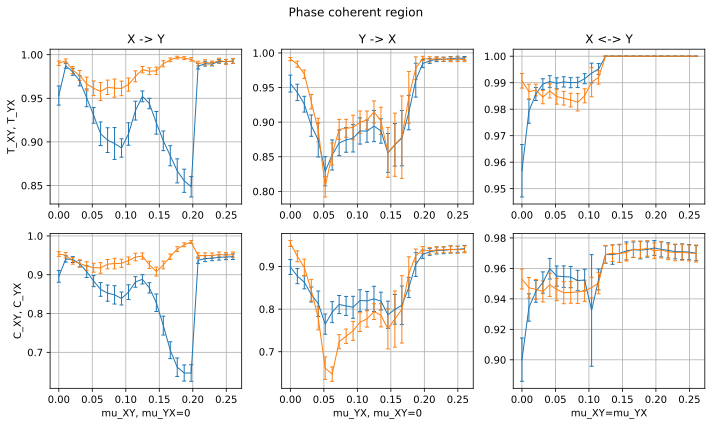

In [16]:
analysis_Xy = np.load("X>Y_coherent.npy")
analysis_XY = np.load("X=Y_coherent.npy")
analysis_xY = np.load("X<Y_coherent.npy")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

correlation_index = np.arange(0, len(analysis_Xy))
mu = 0.26 * correlation_index / (len(analysis_XY) - 1)

averages_Xy = np.mean(analysis_Xy, axis=1)
errors_Xy = np.std(analysis_Xy, axis=1)

averages_XY = np.mean(analysis_XY, axis=1)
errors_XY = np.std(analysis_XY, axis=1)

averages_xY = np.mean(analysis_xY, axis=1)
errors_xY = np.std(analysis_xY, axis=1)

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs[0, 0].errorbar(mu, averages_Xy[:, 2], yerr=errors_Xy[:, 2], linestyle='-', linewidth=1, capsize=2, label='T_XY')
axs[0, 0].errorbar(mu, averages_Xy[:, 3], yerr=errors_Xy[:, 3], linestyle='-', linewidth=1, capsize=2, label='T_YX')
axs[1, 0].errorbar(mu, averages_Xy[:, 0], yerr=errors_Xy[:, 0], linestyle='-', linewidth=1, capsize=2, label='C_XY')
axs[1, 0].errorbar(mu, averages_Xy[:, 1], yerr=errors_Xy[:, 1], linestyle='-', linewidth=1, capsize=2, label='C_YX')

axs[0, 1].errorbar(mu, averages_xY[:, 2], yerr=errors_xY[:, 2], linestyle='-', linewidth=1, capsize=2, label='T_XY')
axs[0, 1].errorbar(mu, averages_xY[:, 3], yerr=errors_xY[:, 3], linestyle='-', linewidth=1, capsize=2, label='T_YX')
axs[1, 1].errorbar(mu, averages_xY[:, 0], yerr=errors_xY[:, 0], linestyle='-', linewidth=1, capsize=2, label='C_XY')
axs[1, 1].errorbar(mu, averages_xY[:, 1], yerr=errors_xY[:, 1], linestyle='-', linewidth=1, capsize=2, label='C_YX')

axs[0, 2].errorbar(mu, averages_XY[:, 2], yerr=errors_XY[:, 2], linestyle='-', linewidth=1, capsize=2, label='T_XY')
axs[0, 2].errorbar(mu, averages_XY[:, 3], yerr=errors_XY[:, 3], linestyle='-', linewidth=1, capsize=2, label='T_YX')
axs[1, 2].errorbar(mu, averages_XY[:, 0], yerr=errors_XY[:, 0], linestyle='-', linewidth=1, capsize=2, label='C_XY')
axs[1, 2].errorbar(mu, averages_XY[:, 1], yerr=errors_XY[:, 1], linestyle='-', linewidth=1, capsize=2, label='C_YX')

# Labels, grid, and title
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[0, 2].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[1, 2].grid(True)

axs[1, 0].set_xlabel('mu_XY, mu_YX=0')
axs[1, 1].set_xlabel('mu_YX, mu_XY=0')
axs[1, 2].set_xlabel('mu_XY=mu_YX')

axs[0, 0].set_ylabel('T_XY, T_YX')
# axs[0, 1].set_ylabel('T_XY, T_YX')
# axs[0, 2].set_ylabel('T_XY, T_YX')
axs[1, 0].set_ylabel('C_XY, C_YX')
# axs[1, 1].set_ylabel('C_XY, C_YX')
# axs[1, 2].set_ylabel('C_XY, C_YX')

axs[0, 0].set_title('X -> Y')
axs[0, 1].set_title('Y -> X')
axs[0, 2].set_title('X <-> Y')

fig.suptitle("Phase coherent region")

# plt.grid(True)
plt.tight_layout()
plt.show()